# Token Pricing Model: Precompute Price Table

## Objective
This notebook precomputes a price table for a token pricing model based on a polynomial curve. The table will be used in a Solidity smart contract to minimize on-chain computations.

---

## Model Overview
The price of the token follows the equation:

\[
P(x) = a \cdot x^k
\]

- **Curvature (`k`)**: A value between 0 and 1 (e.g., \( k = \frac{1}{3} \)).
- **Scaling Factor (`a`)**: Computed to ensure \( P(x_{\text{max}}) = P_{\text{max}} \).
- The integral of \( P(x) \) defines the total supply, evaluated from \( x_1 \) to \( x_2 \).

---

## Parameters
- **Maximum Volume (`x_max`)**: 1,000,000 tokens.
- **Maximum Price (`P_max`)**: \( 10^{18} \), scaled for integer arithmetic.
- **Curvature (`k`)**: Set to \( \frac{1}{3} \).
- **Step Size**: Intervals at which price values are stored, e.g., every 1,000 tokens.

---

## Tasks
1. **Compute the Scaling Factor (`a`)**:
   \[
   a = \frac{P_{\text{max}}}{x_{\text{max}}^k}
   \]

2. **Generate the Price Table**:
   - Calculate \( P(x) \) for \( x \) in the range [0, \( x_{\text{max}} \)].
   - Store values at fixed intervals based on the chosen step size.

3. **Save the Table**:
   - Save the table as a JSON file.
   - Include metadata such as `step`, `P_max`, `k`, and `x_max`.

---

## Output
- A JSON file containing:
  - **Compressed Price Table**: Price values at regular intervals.
  - **Metadata**: Includes `step`, `P_max`, `k`, and `x_max`.

---

## Implementation Notes
- Use integer arithmetic for precision, aligning with Solidity's fixed-point math.
- Optimize the table size by compressing data at regular intervals.
- Ensure compatibility with on-chain usage in Solidity.

---

## Code Outline
1. Import necessary libraries.
2. Define configuration parameters (`x_max`, `P_max`, `k`, `step`).
3. Compute the scaling factor `a`.
4. Generate the price table:
   - Calculate \( P(x) \) at intervals of `step`.
   - Use a loop for computation to handle large `x_max`.
5. Save the table and metadata as a JSON file.

In [10]:
import json

# Configuration
x_max = 1_000_000    # Total volume
n_bins = 100         # Number of bins
k = 1/3              # Curvature
token_base = 10**18  # Token base
a = token_base       # Scale factor to handle fixed-point arithmetic

# Calculate a based on desired maximum price
# Suppose P(x_max) = a * x_max^k = desired_max_price
desired_max_price = 10**18  # Example: 1 token = 1 * 10^18
a = desired_max_price / (x_max**k)

prices = []
cumulative_volumes = []
cumulative_volume = 0

for i in range(n_bins + 1):
    x = (x_max * i) / n_bins
    price = a * (x ** k)
    prices.append(int(price))
    # Calculate the area (volume) for the bin
    if i > 0:
        x_prev = (x_max * (i - 1)) / n_bins
        volume = a / (k + 1) * ((x ** (k + 1)) - (x_prev ** (k + 1)))
        cumulative_volume += int(volume)
    cumulative_volumes.append(int(cumulative_volume))

# Save to JSON for Solidity import
print(json.dumps({
    "prices": prices,
    "cumulativeVolumes": cumulative_volumes
}, indent=4))
#with open('price_table.json', 'w') as f:
#    json.dump({
#        "prices": prices,
#        "cumulativeVolumes": cumulative_volumes
#    }, f, indent=4)


{
    "prices": [
        0,
        215443469003188352,
        271441761659490688,
        310723250595385856,
        341995189335339392,
        368403149864038656,
        391486764116886336,
        412128529980855680,
        430886938006376704,
        448140474655716480,
        464158883361277888,
        479141985706278400,
        493242414866093952,
        506579701910088576,
        519249410185110400,
        531329284591305472,
        542883523318981312,
        553965825675446400,
        564621617328617088,
        574889707894483072,
        584803547642573184,
        594392195276312960,
        603681073679768576,
        612692567522841728,
        621446501190771712,
        629960524947436544,
        638250429885990656,
        646330407009565184,
        654213262037718016,
        661910594802622976,
        669432950082169472,
        676789945210700672,
        683990378670678784,
        691042323001118464,
        697953204690888832,
        70472987320

In [11]:
# output price data as a 32-byte hex string
def to_hex(data):
    return '0x' + ''.join(f'{x:064x}' for x in data)

prices_hex = to_hex(prices)
print(prices_hex)

0x000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002fd68b18f1ce88000000000000000000000000000000000000000000000000003c45ad814eb9180000000000000000000000000000000000000000000000000044fe9266f31520000000000000000000000000000000000000000000000000004bf02d00f39b180000000000000000000000000000000000000000000000000051cd4b681c7f100000000000000000000000000000000000000000000000000056ed7234574434000000000000000000000000000000000000000000000000005b82cb6e750158000000000000000000000000000000000000000000000000005fad1631e39d10000000000000000000000000000000000000000000000000006381d63295434800000000000000000000000000000000000000000000000000671060b921747c000000000000000000000000000000000000000000000000006a64118eeff7e0000000000000000000000000000000000000000000000000006d8595cee3fd7800000000000000000000000000000000000000000000000000707bb8e0ec62b800000000000000000000000000000000000000000000000000734be9663ea238000000000000000000000000000000000000000

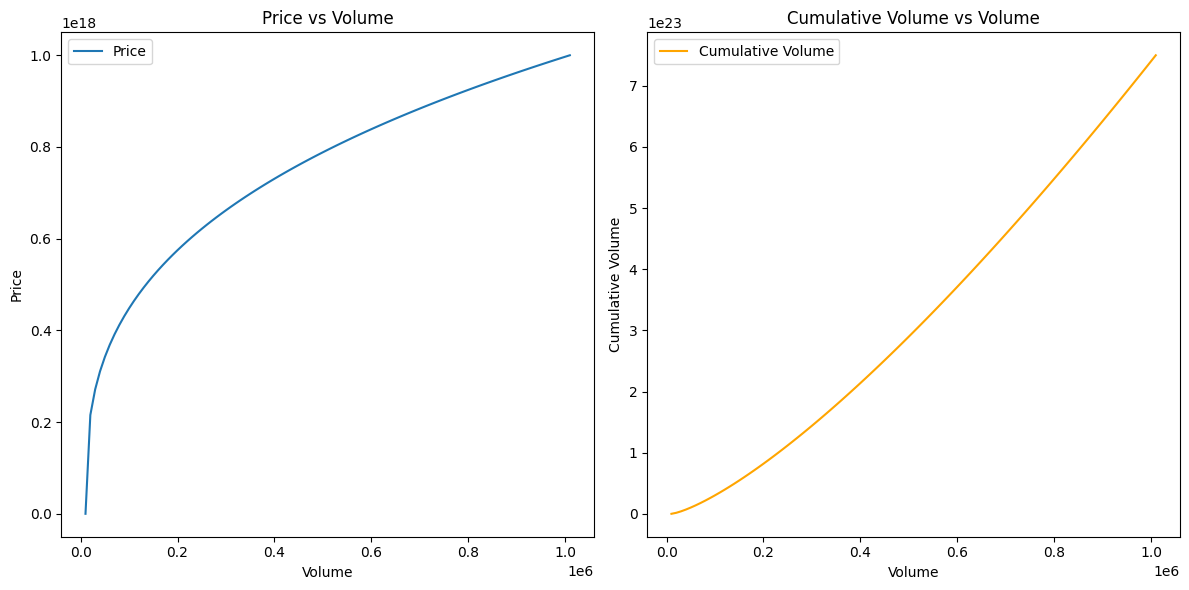

In [12]:
import matplotlib.pyplot as plt

# Generate volume values
volumes = [x_max * i / n_bins for i in range(1, n_bins + 2)]

# Plot prices vs volume
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(volumes, prices, label='Price')
plt.xlabel('Volume')
plt.ylabel('Price')
plt.title('Price vs Volume')
plt.legend()

# Plot cumulative volume vs volume
plt.subplot(1, 2, 2)
plt.plot(volumes, cumulative_volumes, label='Cumulative Volume', color='orange')
plt.xlabel('Volume')
plt.ylabel('Cumulative Volume')
plt.title('Cumulative Volume vs Volume')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# interpolate price at a given volume
def interpolate_price(volume):
    bin_idx = int(volume / x_max * n_bins)
    if bin_idx >= n_bins:
        return prices[-1]
    x = (x_max * bin_idx) / n_bins
    x_next = (x_max * (bin_idx + 1)) / n_bins
    price = a * (x ** k)
    price_next = a * (x_next ** k)
    return price + (price_next - price) * (volume - x) / (x_next - x)

max D: 19110565.162951536
min D: -19110565.16295152


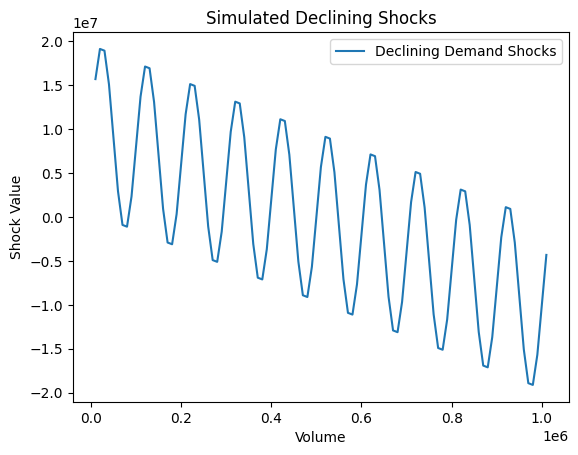

In [14]:
import numpy as np

# simulate demand
frequency = 1e-5
D_values =  [ 10e6 - 20 * volume + 10e6 * np.sin(2 * np.pi * frequency * volume) for volume in volumes]
print("max D:", max(D_values))
print("min D:", min(D_values))
plt.plot(volumes, D_values, label='Declining Demand Shocks')
plt.xlabel('Volume')
plt.ylabel('Shock Value')
plt.title('Simulated Declining Shocks')
plt.legend()
plt.show()


Buy and Sell Demand represented by the first derivative of D

max D_dv: 608.3185307179588
min D_dv: -648.3185307179588


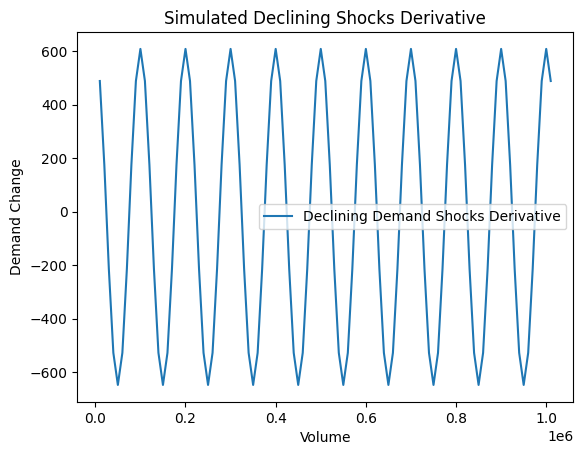

In [15]:
D_dv_values = [ 20e6 * np.pi*frequency * np.cos(2 * np.pi * frequency * volume) - 20 for volume in volumes]
print("max D_dv:", max(D_dv_values))
print("min D_dv:", min(D_dv_values))
plt.plot(volumes, D_dv_values, label='Declining Demand Shocks Derivative')
plt.xlabel('Volume')
plt.ylabel('Demand Change')
plt.title('Simulated Declining Shocks Derivative')
plt.legend()
plt.show()

if demand change is high - simulate buy a large quantity
if demand change is 0 no action 
if demand change is lo/negative - simulate selling

Total Profit: 94871.32
Total Buy Volume: 459218
Total Sell Volume: 377964
Total Trades: 2691


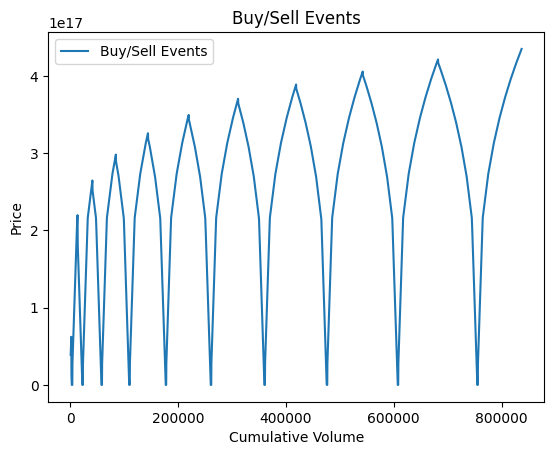

In [23]:
import numpy as np

def simulate_buy_sell_behavior(volumes, D_dv, EDGE=1000, maxQtyScaled=1000):
    demand_max = max(D_dv)
    demand_min = min(D_dv)
    trade_price_qty = []
    buy_sell_events = []
    total_buy_volume = 0
    total_sell_volume = 0
    total_profit = 0
    cumulative_volume = 0
    volume_step = 0

    for i in range(len(D_dv)):
        demand_value = D_dv[i]
        cumulative_volume += volumes[volume_step]
        circulating_supply = total_buy_volume - total_sell_volume
        while circulating_supply <= cumulative_volume:
            if demand_value > 0:  # Buy event
                qty = int(maxQtyScaled * demand_value / demand_max)
                if qty > 0:
                    price = interpolate_price(circulating_supply + qty + EDGE)
                    total_buy_volume += qty
                    trade_price_qty.append((price, qty))
                    buy_sell_events.append(("buy", qty, price))

            elif demand_value < 0:  # Sell event
                if circulating_supply > 0:
                    qty = int(maxQtyScaled * demand_value / demand_min)
                    qty = min(qty, circulating_supply)  # Restrict qty to circulating_supply
                    if qty > 0:
                        price = interpolate_price(max(1, circulating_supply - qty - EDGE))
                        total_sell_volume += qty
                        trade_price_qty.append((price, -qty))
                        buy_sell_events.append(("sell", qty, price))
                        total_profit += price * qty
                else:
                    break
            else:
                break

            circulating_supply = total_buy_volume - total_sell_volume

    return buy_sell_events, total_profit, total_buy_volume, total_sell_volume


buy_sell_events, total_profit, total_buy_volume, total_sell_volume = simulate_buy_sell_behavior(volumes, D_dv_values)

# Results
print("Total Profit: {:.2f}".format(total_profit / token_base))
print("Total Buy Volume:", total_buy_volume)
print("Total Sell Volume:", total_sell_volume)
print("Total Trades:", len(buy_sell_events))

prices = [price for _, _, price in buy_sell_events]
# cumulative volumes
cumulative_volumes = [0]
for _, qty, _ in buy_sell_events:
    cumulative_volumes.append(cumulative_volumes[-1] + qty)
cumulative_volumes = cumulative_volumes[1:]

plt.plot(cumulative_volumes, prices, label='Buy/Sell Events')
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Buy/Sell Events')
plt.legend()
